In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader
from sklearn.metrics import (
    confusion_matrix, f1_score, accuracy_score, 
    precision_score, recall_score, roc_auc_score
)
import numpy as np
from tqdm import tqdm
from dataset import MoleculeDataset
from model import MoleculeNet

import mlflow.pytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/home/kunalkumarsahoo/Playground/Python/GrapHIV/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
2024-09-15 00:17:03.118380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 00:17:03.132235: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 00:17:03.136267: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been 

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch.utils._import_utils'


[INFO] Torch version: 2.2.1+cu121


/home/kunalkumarsahoo/Playground/Python/GrapHIV/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


[INFO] CUDA availability: False
[INFO] PyG version: 2.6.0


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device selected:", device)

mlflow.set_tracking_uri("http://localhost:5000")

Device selected: cpu


In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_one_epoch(epoch, model, train_loader, optimizer, loss_fn):
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0

    for _, batch in enumerate(tqdm(train_loader)):
        batch.to(device)
        optimizer.zero_grad()
        pred = model(batch.x.float(),
                     batch.edge_attr.float(),
                     batch.edge_index,
                     batch.batch)
        # Calculating the loss and gradients
        loss = loss_fn(torch.squeeze(pred), batch.y.float())
        loss.backward()
        optimizer.step()
        # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_labels.append(batch.y.cpu().detach().numpy())
    
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()

    calculate_metrics(all_preds, all_labels, epoch, "train")
    return running_loss / step

def test(epoch, model, test_loader, loss_fn):
    all_preds = []
    all_preds_raw = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for batch in test_loader:
        batch.to(device)  
        pred = model(batch.x.float(), 
                        batch.edge_attr.float(),
                        batch.edge_index, 
                        batch.batch) 
        loss = loss_fn(torch.squeeze(pred), batch.y.float())

         # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_preds_raw.append(torch.sigmoid(pred).cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())
    
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    print(all_preds_raw[0][:10])
    print(all_preds[:10])
    print(all_labels[:10])
    calculate_metrics(all_preds, all_labels, epoch, "test")
    log_conf_matrix(all_preds, all_labels, epoch)
    return running_loss/step

def log_conf_matrix(y_pred, y_true, epoch):
    # Log confusion matrix as image
    cm = confusion_matrix(y_pred, y_true)
    classes = ["0", "1"]
    df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
    cfm_plot.figure.savefig(f'../data/images/cm_{epoch}.png')
    mlflow.log_artifact(f"../data/images/cm_{epoch}.png")

def calculate_metrics(y_pred, y_true, epoch, type):
    print("\nConfusion matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nF1 score:", f1_score(y_true, y_pred))
    print("\nAccuracy score:", accuracy_score(y_true, y_pred))

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    print(f"Precision score:", precision)
    print(f"Recall score:", recall)

    mlflow.log_metric(key=f"Precision-{type}", value=float(precision), step=epoch)
    mlflow.log_metric(key=f"Recall-{type}", value=float(recall), step=epoch)

    try:
        roc = roc_auc_score(y_true, y_pred)
        print("ROC AUC:", roc)
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(roc), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=0.0, step=epoch)
        print("[Exception] ROC AUC: Not Defined")

In [4]:
from mango import Tuner, scheduler
from config import HYPERPARAMETERS, BEST_PARAMETERS, SIGNATURE

In [5]:
def run_one_training(params):
    params = params[0]
    with mlflow.start_run() as run:
        for key in params.keys():
            mlflow.log_param(key, params[key])
        
        print("Loading dataset...")
        train_dataset = MoleculeDataset(root="../data/", filename="HIV_train.csv")
        test_dataset = MoleculeDataset(root="../data/", filename="HIV_test.csv", test=True)
        params["model_edge_dim"] = train_dataset[0].edge_attr.shape[1]

        train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=True)

        print("Loading model...")
        model_params = {k: v for k, v in params.items() if k.startswith("model_")}
        model = MoleculeNet(feature_size=train_dataset[0].x.shape[1], model_params=model_params)
        model = model.to(device)
        print("Number of parameters:", count_parameters(model))
        mlflow.log_param("num_params", count_parameters(model))

        # < 1 increases precision, > 1 recall
        weight = torch.tensor([params["pos_weight"]], dtype=torch.float32).to(device)
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=weight)
        optimizer = optim.SGD(model.parameters(), lr=params["learning_rate"], momentum=params["sgd_momentum"], weight_decay=params["weight_decay"])
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=params["scheduler_gamma"])

        # Start training
        best_loss = 1000
        early_stopping_counter = 0
        for epoch in range(300):
            if early_stopping_counter <= 10:
                # Training
                model.train()
                loss = train_one_epoch(epoch, model, train_loader, optimizer, loss_fn)
                print(f"Epoch {epoch} | Train loss: {loss}")
                mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)

                # Validation
                model.eval()
                if epoch % 5 == 0:
                    loss = test(epoch, model, test_loader, loss_fn)
                    print(f"Epoch {epoch} | Validation loss: {loss}")
                    mlflow.log_metric(key="Validation loss", value=float(loss), step=epoch)

                    if float(loss) < best_loss:
                        best_loss = loss
                        mlflow.pytorch.log_model(model, "model", signature=SIGNATURE)
                        early_stopping_counter = 0
                    else:
                        early_stopping_counter += 1
                
                scheduler.step()

            else:
                print("Early stopping due to no improvement.")
                return [best_loss]
    
    print("Finishing training with best validation loss:", best_loss)
    return [best_loss]

Running Hyperparameter search: 
Loading dataset...
Loading model...
Number of parameters: 314465


100%|██████████| 497/497 [01:29<00:00,  5.57it/s]



Confusion matrix:
 [[ 5968 25787]
 [ 5519 26236]]

F1 score: 0.6263219460956337

Accuracy score: 0.5070697527948355
Precision score: 0.5043153989581531
Recall score: 0.8262005983309715
ROC AUC: 0.5070697527948355
Epoch 0 | Train loss: 0.6965196919393252
[[0.49556014]
 [0.5101417 ]
 [0.49957067]
 [0.5120769 ]
 [0.51504093]
 [0.48992765]
 [0.51254153]
 [0.5105129 ]
 [0.52010846]
 [0.5136032 ]]
[0. 1. 0. 1. 1. 0. 1. 1. 1. 1.]
[0 0 0 0 0 0 0 0 0 0]

Confusion matrix:
 [[1709 6220]
 [  30  267]]

F1 score: 0.07871462264150944

Accuracy score: 0.24021395575006077
Precision score: 0.041159241560043164
Recall score: 0.898989898989899
ROC AUC: 0.5572638989211067
Epoch 0 | Validation loss: 0.7105811421687787


100%|██████████| 497/497 [01:31<00:00,  5.45it/s]



Confusion matrix:
 [[ 7548 24207]
 [ 6660 25095]]

F1 score: 0.6191939005884748

Accuracy score: 0.513982050070855
Precision score: 0.5090057198490934
Recall score: 0.7902692489371752
ROC AUC: 0.513982050070855
Epoch 1 | Train loss: 0.6891971581898465


100%|██████████| 497/497 [01:31<00:00,  5.41it/s]



Confusion matrix:
 [[ 9041 22714]
 [ 7880 23875]]

F1 score: 0.6094914735014807

Accuracy score: 0.51828058573453
Precision score: 0.5124600227521517
Recall score: 0.7518501023460872
ROC AUC: 0.51828058573453
Epoch 2 | Train loss: 0.6857777769177013


 25%|██▍       | 123/497 [00:23<01:10,  5.30it/s]
2024/09/15 00:22:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run casual-newt-792 at: http://localhost:5000/#/experiments/0/runs/4a40e168d03b4feaa1ecd9fd23ec5d83.
2024/09/15 00:22:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


KeyboardInterrupt: 

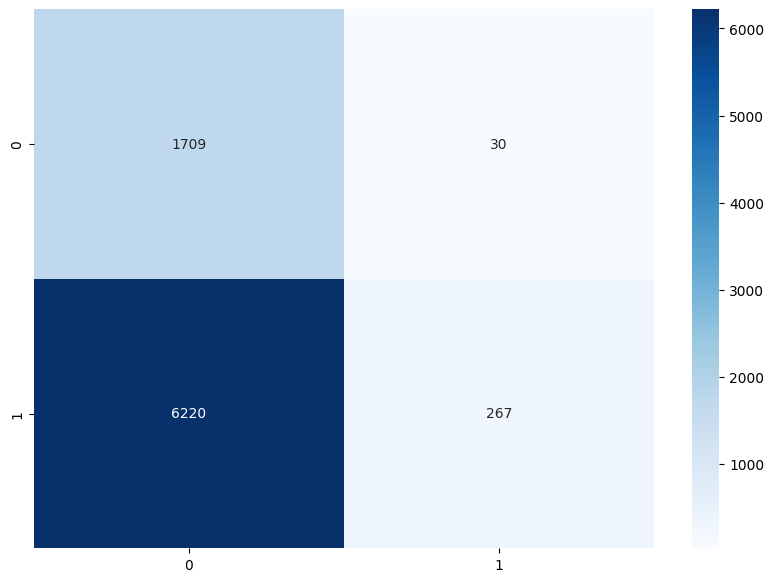

In [6]:
print("Running Hyperparameter search: ")
config = dict()
config["optimizer"] = "Bayesian"
config["num_iteration"] = 100

tuner = Tuner(HYPERPARAMETERS, objective=run_one_training, conf_dict=config)
results = tuner.minimize()